In [1]:
from pytorch_pretrained_vit import ViT
from Image_Encoding import Image_Encoding
from torchvision import transforms
from EEG_Image_Dataset import *
from torch import nn
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pytorch_pretrained_vit import ViT
import pickle
import torch.nn.functional as F
import cv2
import sys
import os
import tqdm
import random
import math
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
import numpy as np
import models
import importlib
import argparse
import matplotlib.pyplot as plt
import time

In [2]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=512,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [3]:
Image_Encoder = ViT('B_16_imagenet1k', pretrained=True)

#Freeze pretrained weights except last two fc layers
for param in Image_Encoder.parameters():
    param.requires_grad = False
Image_Encoder.cuda()
print("Copied to CUDA")

return_layers = {'norm':'norm'}


mid_getter = MidGetter(Image_Encoder ,return_layers=return_layers, keep_output = True)

with open('/users/sbr/data/Image_data/image_path.pkl', 'rb') as f:
    image_path = pickle.load(f)
    
loaders = {split: DataLoader(Splitter(EEG_Image_Dataset('/users/sbr/data/eeg_55_95_std.pth', image_path, split), split_path = '/users/sbr/data/block_splits_by_image_all.pth', split_name = split), batch_size = 16, drop_last = True, shuffle = True) for split in ["train", "val", "test"]}

Loaded pretrained weights.
Copied to CUDA


In [4]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = mid_getter
        self.EEG_encoder = EEG_Encoder
        self.image_projection = ProjectionHead(embedding_dim=768)
        self.EEG_projection = ProjectionHead(embedding_dim=1000)

    def forward(self, EEG, image, label, image_label):
        image_features, image_class = self.image_encoder(image)
        image_features = image_features['norm'][:,0]
        
        EEG_features, EEG_class = self.EEG_encoder(EEG)
        image_embeddings = self.image_projection(image_features)
        EEG_embeddings = self.EEG_projection(EEG_features)

        logits = (EEG_embeddings @ image_embeddings.T)
        images_similarity = image_embeddings @ image_embeddings.T
        EEG_similarity = EEG_embeddings @ EEG_embeddings.T
        
        targets = F.softmax((images_similarity + EEG_similarity) / 2, dim=-1)
        
        EEG_s_loss = cross_entropy(logits, targets, reduction='none')
        image_s_loss = cross_entropy(logits.T, targets.T, reduction='none')
        CLIP_loss =  (image_s_loss + EEG_s_loss) / 2.0
        
        image_c_loss = F.cross_entropy(image_class, label)
        EEG_c_loss = F.cross_entropy(EEG_class, label)
        
        loss = CLIP_loss + ((image_c_loss + EEG_c_loss) / 2.0) * 0.1
        
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [5]:
model = torch.load('/users/sbr/code/Image/CLIP_epoch_15.pth')

In [6]:
model.eval()
model.to('cuda')
return_layers = {'norm':'norm'}
mid_getter = MidGetter(Image_Encoder, return_layers=return_layers, keep_output = True)

valid_image_embeddings = []
image_labels = []
with torch.no_grad():
    for batch in tqdm.tqdm(loaders['test']):
        _, image, _, image_label = batch
        image = image.to('cuda')
        image_features, _ = mid_getter(image)
        image_features = image_features['norm'][:, 0]
        image_embeddings = model.image_projection(image_features)
        valid_image_embeddings.append(image_embeddings)
        image_labels.append(image_label)
        
image_embeddings = torch.cat(valid_image_embeddings)
image_labels = np.array(image_labels).ravel()

100%|█████████████████████████████████████████| 124/124 [00:29<00:00,  4.27it/s]


In [7]:
label_list = [
    "sorrel",
    "parachute",
    "iron",
    "anemone fish",
    "espresso maker",
    "coffee mug",
    "mountain bike",
    "revolver",
    "giant panda",
    "daisy",
    "canoe",
    "lycaenid",
    "German shepherd",
    "running shoe",
    "jack-o'-lantern",
    "cellular telephone",
    "golf ball",
    "desktop computer",
    "broom",
    "pizza",
    "missile",
    "capuchin",
    "pool table",
    "mailbag",
    "convertible",
    "folding chair",
    "pajama",
    "mitten",
    "electric guitar",
    "reflex camera",
    "grand piano",
    "mountain tent",
    "banana",
    "bolete",
    "digital watch",
    "African elephant",
    "airliner",
    "electric locomotive",
    "radio telescope",
    "Egyptian cat"
]


In [76]:
def find_matches(model, image_embeddings, EEG, eeg_label, n=9):
    EEG = EEG.to('cuda')
    
    EEG_feature, _ = model.EEG_encoder(EEG)
    EEG_embeddings = model.EEG_projection(EEG_feature)
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    EEG_embeddings_n = F.normalize(EEG_embeddings, p=2, dim=-1)
    dot_similarity = EEG_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    image_label = [image_labels[idx] for idx in indices]
    
    class_labels = list(map(lambda x: x.split('_')[0], image_label))
    
    final_list = ['/users/sbr/data/Image_data/' + class_label + '/' + label + '.JPEG' for (class_label, label) in zip(class_labels, image_label)]
    final_list = np.unique(final_list)
    
    for idx, image_path in enumerate(final_list):
        plt.figure()
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.title(label_list[eeg_label[0]])
        plt.axis('off')
        plt.imshow(image)
        plt.savefig('image_for_EEG{}_{}'.format(label_list[eeg_label[0]], idx))
        plt.show()

In [77]:
for EEG, _, label, _ in loaders['test']:
    test_eeg = EEG
    eeg_label = label
    break

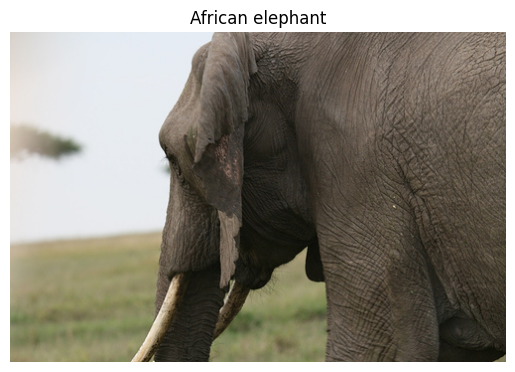

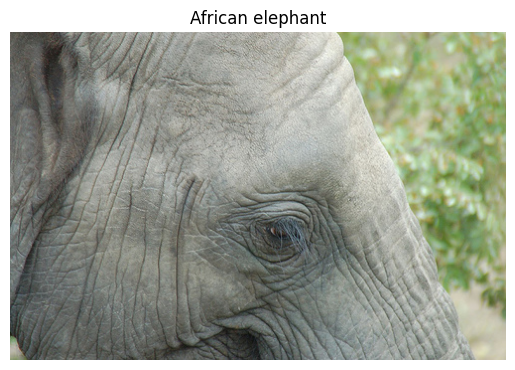

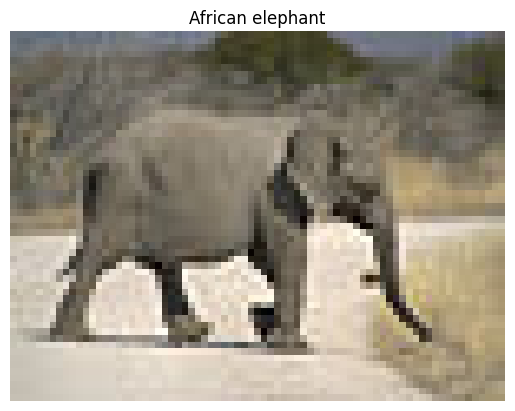

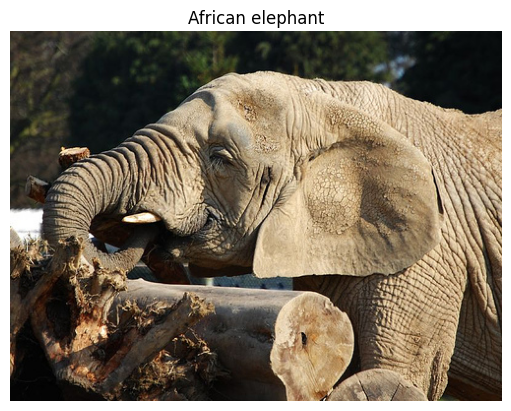

In [78]:
find_matches(model,
             image_embeddings,
             test_eeg[:1],
             eeg_label[:1],
             n=9)